In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from timeseries import *
from models import *
import pickle 
import numpy as np
from sklearn.model_selection import train_test_split
from fastai.distributed import *
import neptune
from neptunecontrib.monitoring.fastai import NeptuneMonitor


/opt/anaconda/envs/pytorch/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [4]:
x, y = pickle.load(open("data/train.pkl", "rb"))

In [5]:
test_name, x_test = pickle.load(open("data/test.pkl", "rb"))

In [6]:
x.mean(), x.std(), x.min(), x.max()

(-6.63823368281504e-06, 79.22496224741775, -5831.451171875, 6120.92822265625)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42123456)

# Power Spectral Densities 

In [8]:
ts = x_train[0]
ts

array([[ 19.273817, -43.025135, -39.102345,  12.084982, ...,  12.05062 ,  53.035038,   9.12352 , -50.392281],
       [ 15.817652, -47.764786, -42.307041,  12.479721, ...,   9.12736 ,  52.942169,   9.512124, -50.704594],
       [ 17.860075, -48.699497, -42.863831,  14.577107, ...,  15.446495,  61.463081,  14.91027 , -49.9902  ],
       [ 18.501114, -47.557201, -40.669018,  17.480841, ...,  15.327809,  60.725906,  14.026532, -50.06794 ],
       ...,
       [ 29.664776, -33.200687, -24.426916,  32.456264, ...,   4.703967,  49.441025,   2.881808, -60.641384],
       [ 32.000565, -34.738518, -29.226196,  29.447924, ...,   1.925027,  52.354599,   7.08275 , -60.940639],
       [ 27.685778, -38.211552, -31.32745 ,  28.059948, ...,   6.257125,  54.55426 ,   8.288437, -57.760056],
       [ 32.997791, -29.7715  , -21.593296,  32.391415, ...,   5.493442,  47.460251,  -1.410295, -65.653282]])

In [9]:
ts.shape

(12, 4096)

## Yule Walker 

In [10]:
from spectrum import aryule, Periodogram, arma2psd

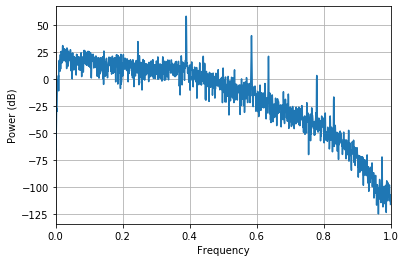

In [11]:
p = Periodogram(ts[0], sampling=2)  # y is a list of list hence the y[0]
p.plot(label='Model ouput')

In [12]:
AR, P, k = aryule(ts[0], 20)

In [13]:
from pylab import log10, linspace, plot, xlabel, ylabel, legend, randn, pi

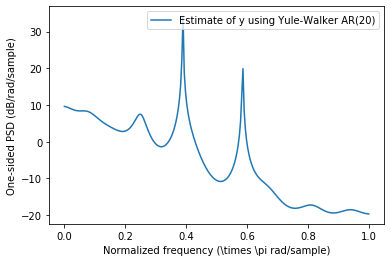

In [14]:
PSD = arma2psd(AR, NFFT=512)
PSD = PSD[len(PSD):len(PSD)//2:-1]
plot(linspace(0, 1, len(PSD)), 10*log10(abs(PSD)*2./(2.*pi)),
    label='Estimate of y using Yule-Walker AR(20)')
xlabel(r'Normalized frequency (\times \pi rad/sample)')
ylabel('One-sided PSD (dB/rad/sample)')
legend()

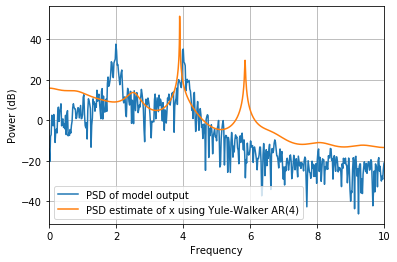

In [15]:
from pylab import legend, randn
import scipy.signal
from spectrum import Periodogram, pyule
a = [1, -2.2137, 2.9403, -2.1697, 0.9606]
y = scipy.signal.lfilter([1], a, randn(1, 1024))
p = Periodogram(y[0], sampling=20)
p.plot()
p = pyule(ts[0], 20, sampling=20, scale_by_freq=False)
p.plot()
legend(['PSD of model output','PSD estimate of x using Yule-Walker AR(4)'])

## PBURG

In [16]:
from spectrum import arma2psd, arburg

In [17]:
AR, rho, ref = arburg(ts[0], 20)

In [18]:
PSD = arma2psd(AR, rho=rho, NFFT=512)
PSD = PSD[len(PSD):len(PSD)//2:-1]

Text(0.5, 0, 'Normalized frequency (\times \\pi rad/sample)')

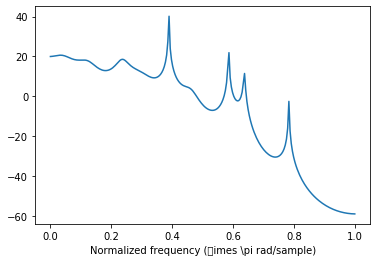

In [19]:
from pylab import log10, pi,linspace, plot, xlabel, randn

plot(linspace(0, 1, len(PSD)), 10*log10(abs(PSD)*2./(2.*pi)))
xlabel('Normalized frequency (\times \pi rad/sample)')

In [38]:
PSD.shape

(255,)

# ICA

In [20]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=1, random_state=0)
X_transformed = transformer.fit_transform(ts)

In [21]:
X_transformed.shape

(12, 1)

In [22]:
X_transformed

array([[-0.148565],
       [-0.190974],
       [-0.262085],
       [-0.278098],
       [-0.278882],
       [-0.033977],
       [-0.149911],
       [-0.007167],
       [ 0.336708],
       [ 0.274711],
       [ 0.028064],
       [ 0.710177]])

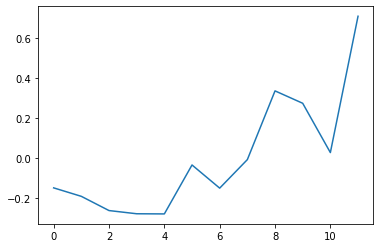

In [23]:
plot(X_transformed)

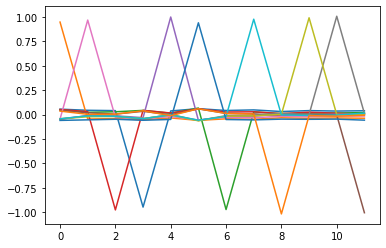

In [24]:
transformer = FastICA(random_state=0)
X_transformed = transformer.fit_transform(ts)
plot(X_transformed)

In [25]:
transformer.mixing_.shape

(4096, 12)

In [26]:
ts.shape

(12, 4096)

In [27]:
X_transformed.shape

(12, 12)

# Model

In [28]:
scale_type = 'standardize'
scale_by_channel = True
scale_by_sample  = False 
scale_range = (-1, 1)
act_fn = 'prelu'
nf = 64
bs = 16
pool = nn.AdaptiveAvgPool1d

In [29]:
import torch
import torch.nn as nn
from models.layers import *

class SeModule(nn.Module):
    def __init__(self, ch, reduction, act_fn='relu'):
        super().__init__()
        nf = math.ceil(ch//reduction/8)*8
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.conv1 = convlayer(ch, nf, 1, act_fn=act_fn)
        self.conv2 = convlayer(nf, ch, 1, act_fn=False)
        
    def forward(self, x):
        res = self.pool(x)
        res = self.conv1(res)
        res = self.conv2(res)
        res = nn.functional.sigmoid(res)
        return x * res
 
       
class ResBlock(nn.Module):
    def __init__(self, ni, nf, ks=[7, 5, 3], act_fn='relu'):
        super().__init__()
        self.conv1 = convlayer(ni, nf, ks[0], act_fn=act_fn)
        self.conv2 = convlayer(nf, nf, ks[1], act_fn=act_fn)
        self.conv3 = convlayer(nf, nf, ks[2], act_fn=False)
        self.se = SeModule(nf, 16, act_fn=act_fn)
        # expand channels for the sum if necessary
        self.shortcut = noop if ni == nf else convlayer(ni, nf, ks=1, act_fn=False)
        self.act_fn = get_act_layer(act_fn)

    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # Squeeze and Excitation
        x = self.se(x)
        # Shortcut
        sc = self.shortcut(res)
        # Residual
        x += sc
        x = self.act_fn(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self,c_in, c_out, nf=64, pool=nn.AdaptiveAvgPool1d, act_fn='relu'):
        super().__init__()
        self.block1 = ResBlock(c_in, nf, ks=[7, 5, 3], act_fn=act_fn)
        self.block2 = ResBlock(nf, nf * 2, ks=[7, 5, 3], act_fn=act_fn)
        self.block3 = ResBlock(nf * 2, nf * 2, ks=[7, 5, 3], act_fn=act_fn)
        self.gap = pool(1)
        self.fc = nn.Linear(nf * 2, c_out)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x).squeeze(-1)
        return self.fc(x)

# Load Data

In [30]:
def _roll(x, max_shift_pct=0.7, direction=0):
    '''This roll'''
    if int(direction) not in [-1, 0, 1]: 
        raise ValueError("Direction must be -1(left) 0(bidirectional) or 1(right)")
    direction = random.choice([-1, 1]) if direction == 0 else direction
    width = x.shape[-1]
    roll_by = int(width*random.random()*max_shift_pct*direction)
    if len(x.shape) < 2:
        sg = x.roll(roll_by)
    else:
        sg = torch.stack([ c.roll(roll_by) for c in x])
    return sg
TSRoll = TSTransform(_roll)

def _flip(x):
    '''This flip'''
    if random.random() < .5:
        return x.flip(-1)
    return x
TSFlip = TSTransform(_flip)

transformer = FastICA(random_state=0)
def _ica(x):
    X_transformed = transformer.fit_transform(ts)
    return torch.from_numpy(X_transformed).type_as(x)
TSIca = TSTransform(_ica) 

In [31]:
data = (ItemLists(Path("data"), TSList(x_train),TSList(x_val))
        .label_from_lists(y_train, y_val)
        .transform(tfms=([TSIca],[TSIca]))
        .databunch(bs=bs, val_bs=bs * 2)
    )

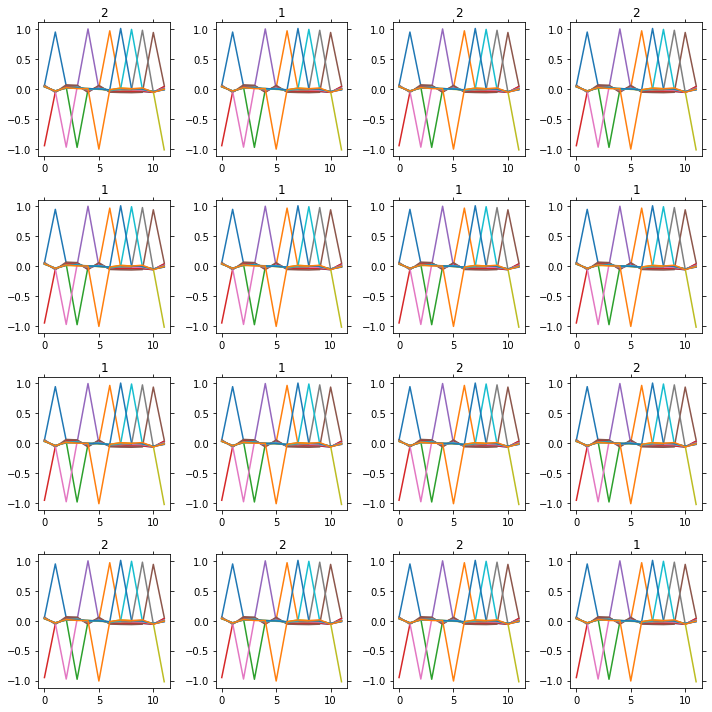

In [32]:
data.show_batch()

# Training

In [33]:
model = ResNet(data.features, data.c, act_fn=act_fn, nf=nf, pool=pool)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa], opt_func=Ranger)

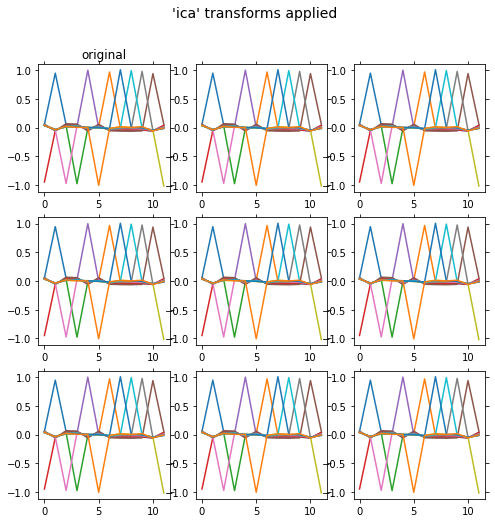

Learner(data=TSDataBunch;

Train: LabelList (512 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,1,2,2
Path: .;

Valid: LabelList (128 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
2,2,1,1,2
Path: .;

Test: None, model=ResNet(
  (block1): ResBlock(
    (conv1): Sequential(
      (0): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (conv2): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )

In [34]:
learn.show_tfms()

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


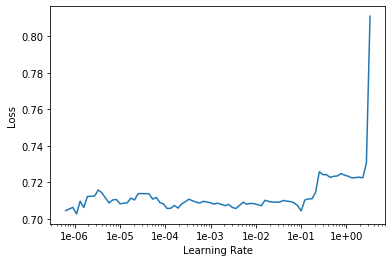

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(100, 1e-3)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.712754,0.701357,0.484375,0.000000,00:03
1,0.706394,0.715408,0.484375,0.000000,00:03
2,0.700940,0.746589,0.484375,0.000000,00:03
3,0.697414,0.754785,0.484375,0.000000,00:03
4,0.695451,0.750019,0.484375,0.000000,00:03
5,0.694824,0.744581,0.484375,0.000000,00:03
6,0.694478,0.742079,0.484375,0.000000,00:03
7,0.694979,0.715182,0.484375,0.000000,00:03
8,0.695260,0.730057,0.484375,0.000000,00:03
9,0.695480,0.700581,0.484375,0.000000,00:03


KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(100, 1e-4)